In [1]:
import sys
sys.path.append('./')
import utils
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import fdrcorrection

from matplotlib import rc
rc('text', usetex=False)
# rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 20, 
      'axes.titlesize': 20, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("ticks")

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23 
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams["legend.title_fontsize"] = 22

# load stuff:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
# keep DE genes only:
res = res[((res.padj58 < 0.05) | (res.padj50 < 0.05)) & (res.Sign == 'Same')] 

cols = ['externalgenename', 'log2FoldChange{0}', 'padj{0}']
fetch = lambda x: [c.format(x) for c in cols]
rename = lambda x: {'log2FoldChange{0}'.format(x): 'log2FoldChange', 'padj{0}'.format(x): 'padj'}

# data wrangling to create a new dataframe that contains the `results` data, but will also include
# the tissue annotations
a = res[fetch('58')].rename(columns=rename('58'))
b = res[fetch('50')].rename(columns=rename('50'))
a['data'] = '58'
b['data'] = '50'
annotated_data = pd.concat([a[a.padj < 0.05], b[b.padj < 0.05]])
cat_type = pd.CategoricalDtype(categories=['50', '58'], ordered=True)
annotated_data.data = annotated_data.data.astype(cat_type)

# load tissue dictionary:
tissues = utils.load_tissues(res.index, 5, 30)
annotated_data = annotated_data.join(tissues.set_index('wbid')).dropna(subset=['tissue'])
annotated_data.head()

tissues originally: 1535
tissues afterwards: 264


,externalgenename,log2FoldChange,padj,data,external_gene_name,target_id,species,tissue
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,body wall musculature
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,hypodermis
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,intestine
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,neuron
WBGene00000023,abt-5,-0.342206,0.000949,50,abt-5,Y53C10A.9,Caenorhabditis elegans,head


In [2]:
# perform a binomial test for change in direction:
alpha = 0.05
data = utils.test_tissue_direction(res[res.padj58 < 0.05], tissues)
data_50 = utils.test_tissue_direction(res[res.padj50 < 0.05], tissues, col='log2FoldChange50')

data = pd.concat([data, data_50], keys=['58', '50']
                ).reset_index().rename(
                columns={'level_0': 'data'}
                ).drop('level_1', axis=1)

data = utils.fdr_correct(data)
data.sort_values('fdr', inplace=True)

data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)
data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)

# keep only significant results:
keep = data.groupby('tissue').sig.sum()
data = data[data.tissue.isin(keep[keep > 0].index)]

m = 'There were {0} tissues that changed more in one direction than expected by random chance in dataset {1}'
for n, g in data.groupby('data'):
    print(m.format(len(g), n))

There were 47 tissues that changed more in one direction than expected by random chance in dataset 50
There were 53 tissues that changed more in one direction than expected by random chance in dataset 58


In [3]:
remove = ['Cell', 'tail', 'head', 'male gonad', 'gonad', ]  # so broad. why ever have these terms...
remove = utils.similarity_trimming(data.tissue.unique(), tissues, remove)
print('The following list of tissues will be removed from the plot', list(set(remove)))

The following list of tissues will be removed from the plot ['phasmid neuron', 'anal depressor muscle', 'vulval muscle', 'hyp11', 'virL', 'gonad', 'ABa', 'hyp8', 'hyp12', 'ABp', 'anterior distal tip cell', 'nervous system', 'Psub1', 'mu-int-L', 'AB', 'head', 'posterior distal tip cell', 'Psub2', 'EMS', 'tail', 'rectal epithelium', 'tail neuron', 'hypodermis', 'Z3', 'excretory cell', 'body region', 'male gonad', 'ventral cord neuron', 'hermaphrodite gonad', 'hyp9', 'Cell', 'mu-int-R', 'reproductive system', 'Z2', 'P0']


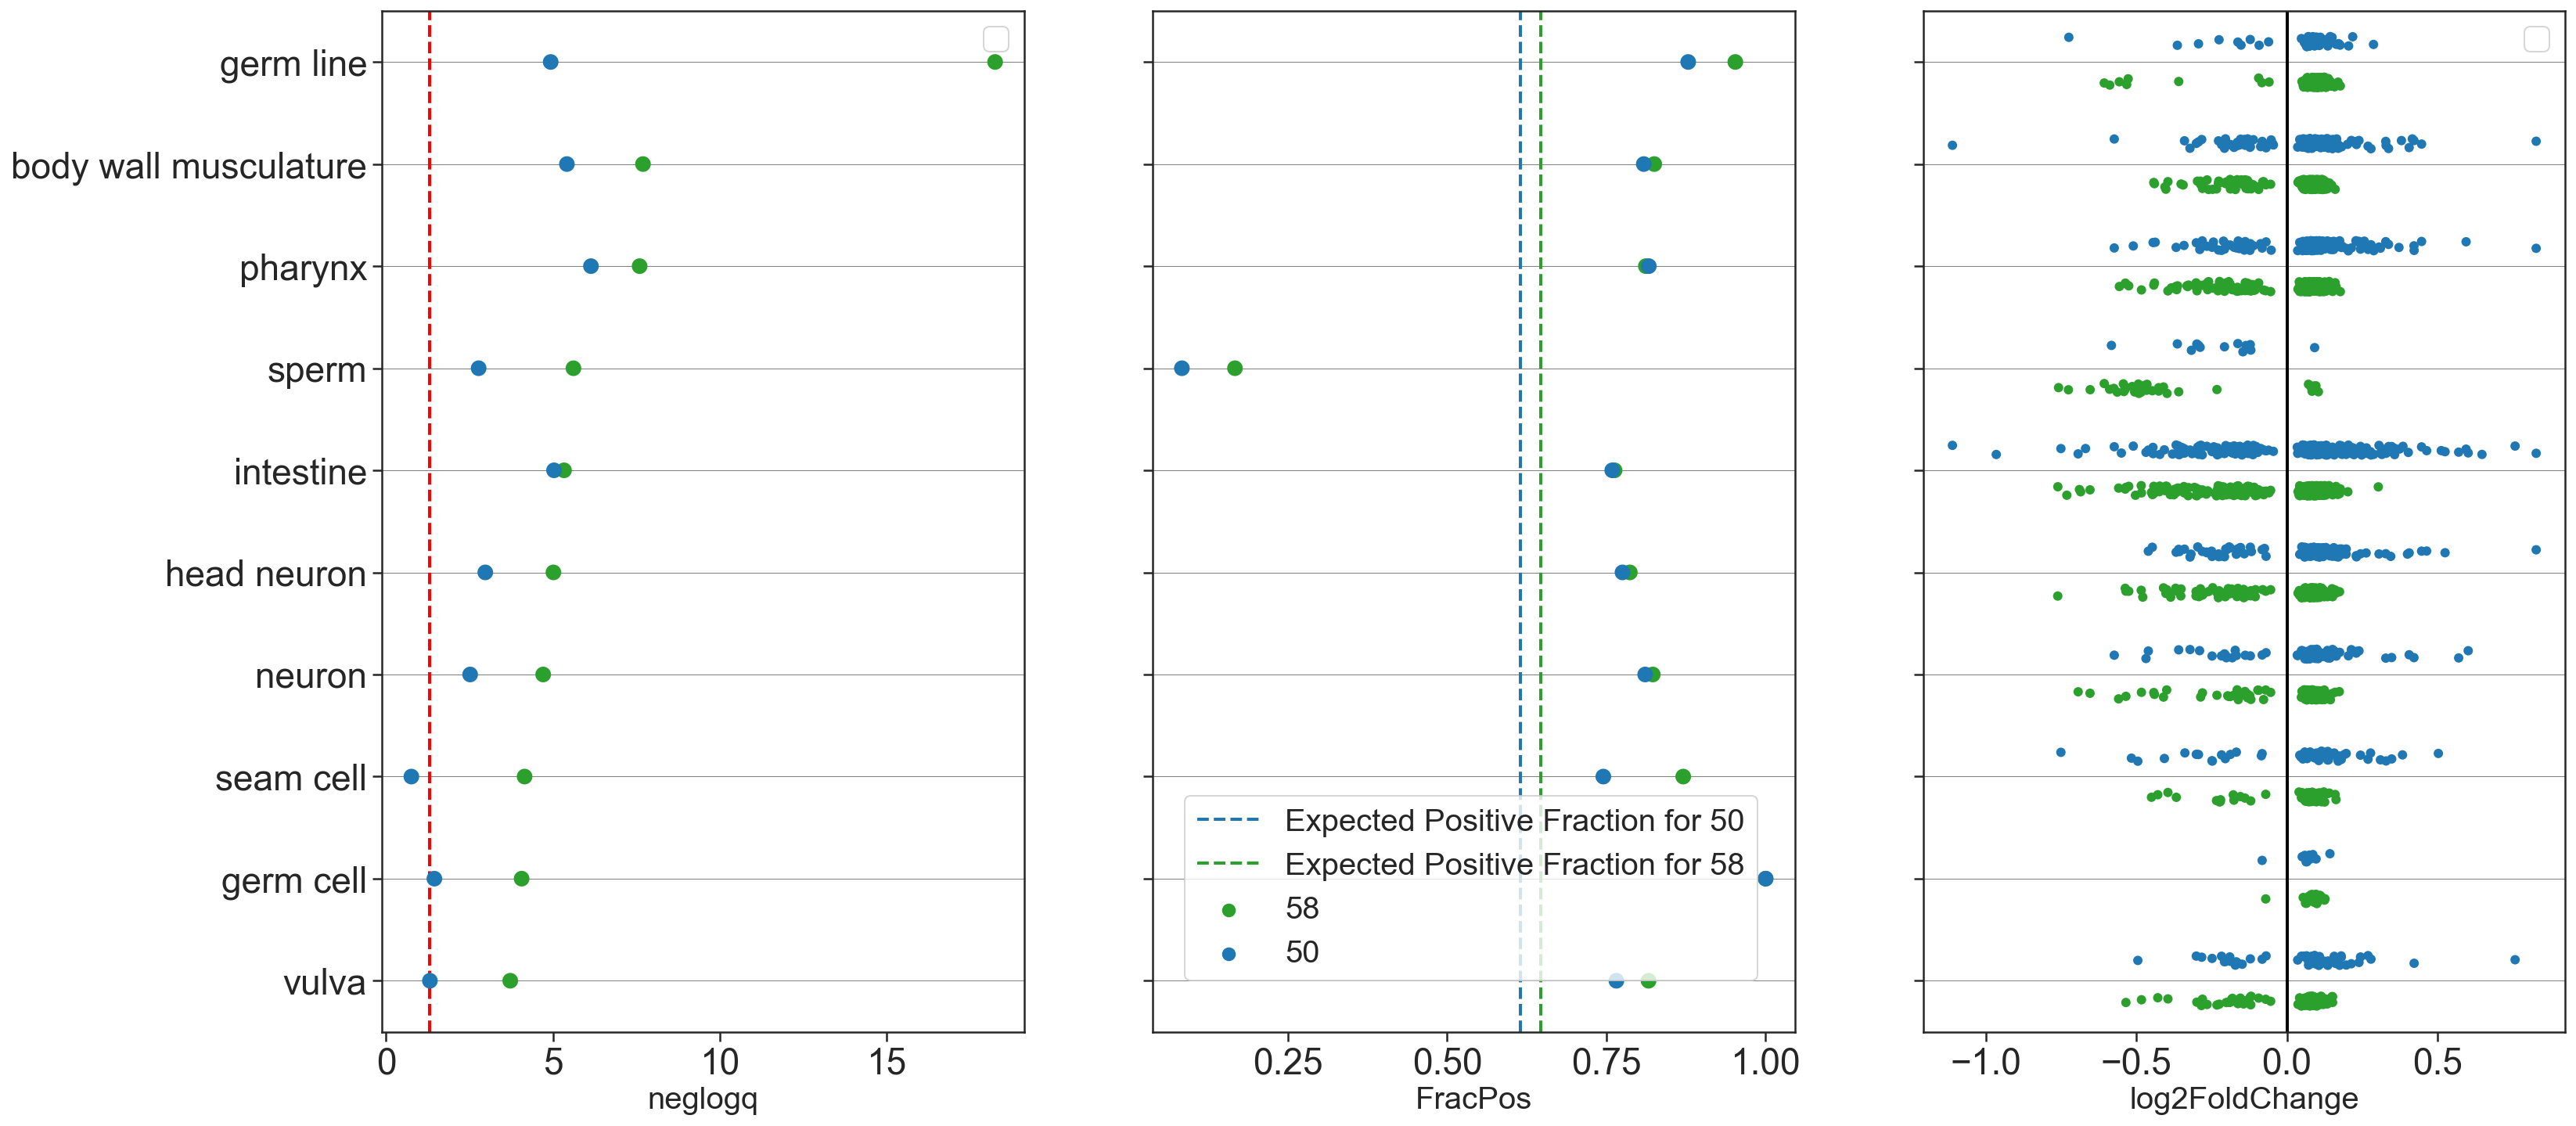

In [4]:
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)].head(15)#.sort_values('fdr').head(10)
to_plot = data[(data.tissue.isin(to_plot.tissue))]

tissues_plotted = to_plot.tissue.unique()
fig, ax, legend = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha)

plt.savefig('../figs/tissue_GSEA.svg', bbox_inches='tight', transparent=True)

In [5]:
res = pd.read_csv('../data/diff_exp/DE_pqm1_50.csv', index_col=0)
res = res[(res.padj < 0.05)] #& (res.MinCountsDetected > 20)]

tissues = utils.load_tissues(res.index, 5, 30)
res = res.reindex(tissues.wbid.unique()).dropna()

alpha = 0.05
data = utils.test_tissue_direction(res[res.padj < 0.05],
                                   tissues=tissues,
                                   col='log2FoldChange')
data = utils.fdr_correct(data)
data.sort_values('fdr', inplace=True)

data['MeanFracPos'] = data.groupby('tissue').FracPos.transform(np.mean)

m = 'There were {0} tissues that changed more in one direction than expected by random chance in dataset {1}'
print(m.format(len(data[data.sig == True]), n))

tissues originally: 2132
tissues afterwards: 737
There were 63 tissues that changed more in one direction than expected by random chance in dataset 58


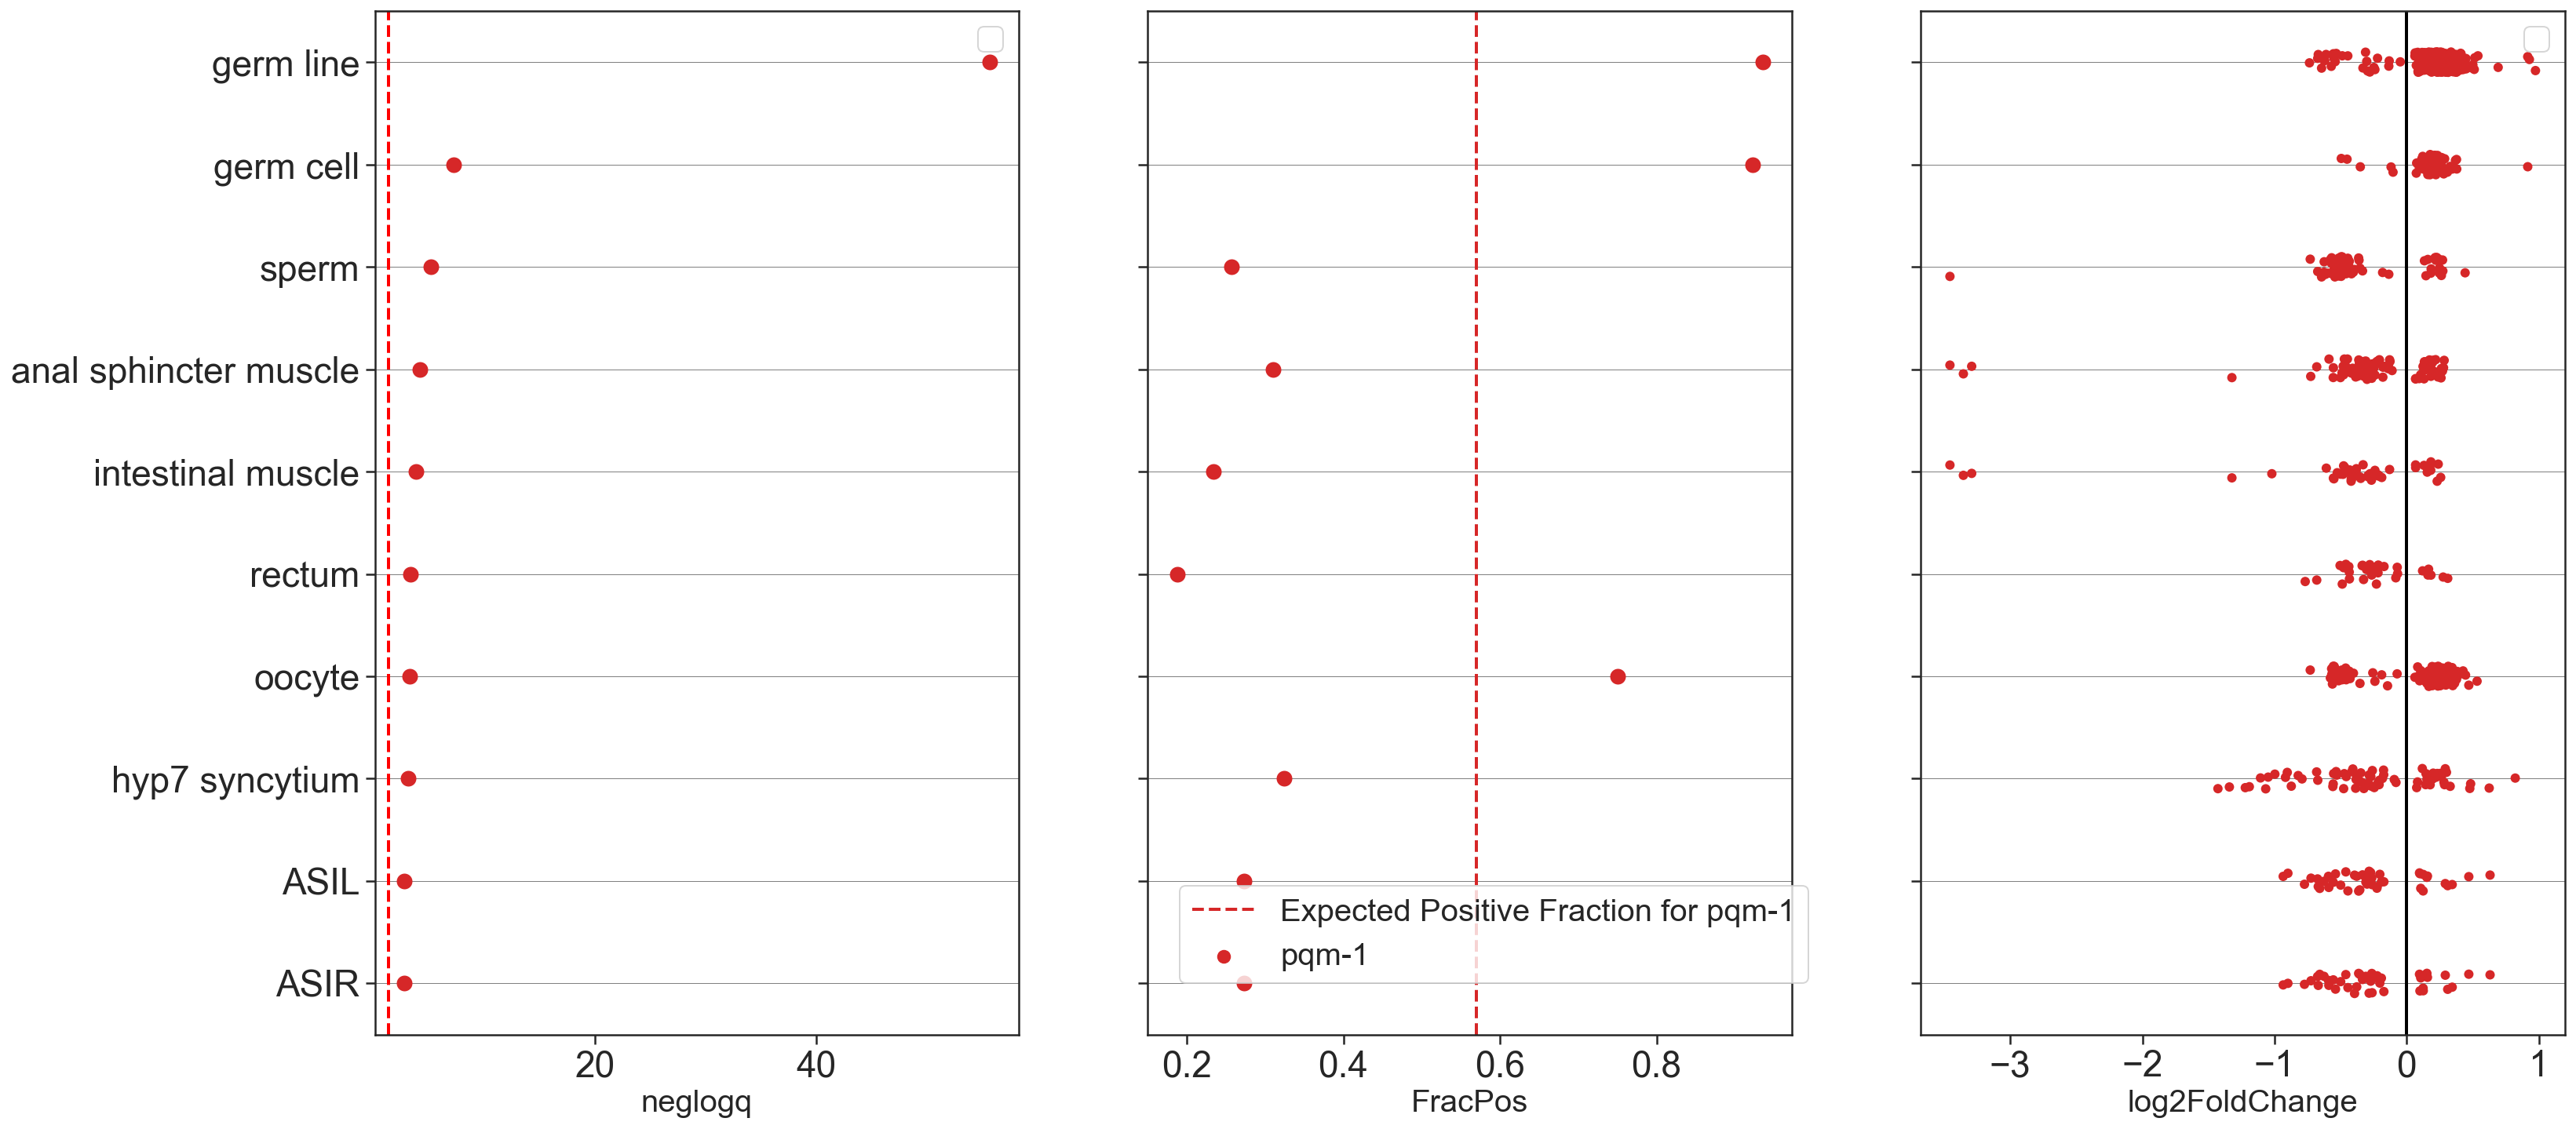

In [6]:
data['data'] = 'pqm-1'
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)].head(10)#.sort_values('fdr').head(10)
annotated_data = res.join(tissues.set_index('wbid'))
annotated_data['data'] = 'pqm-1'

fig, ax, legend = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha, hue='data', palette={'pqm-1': 'tab:red'})

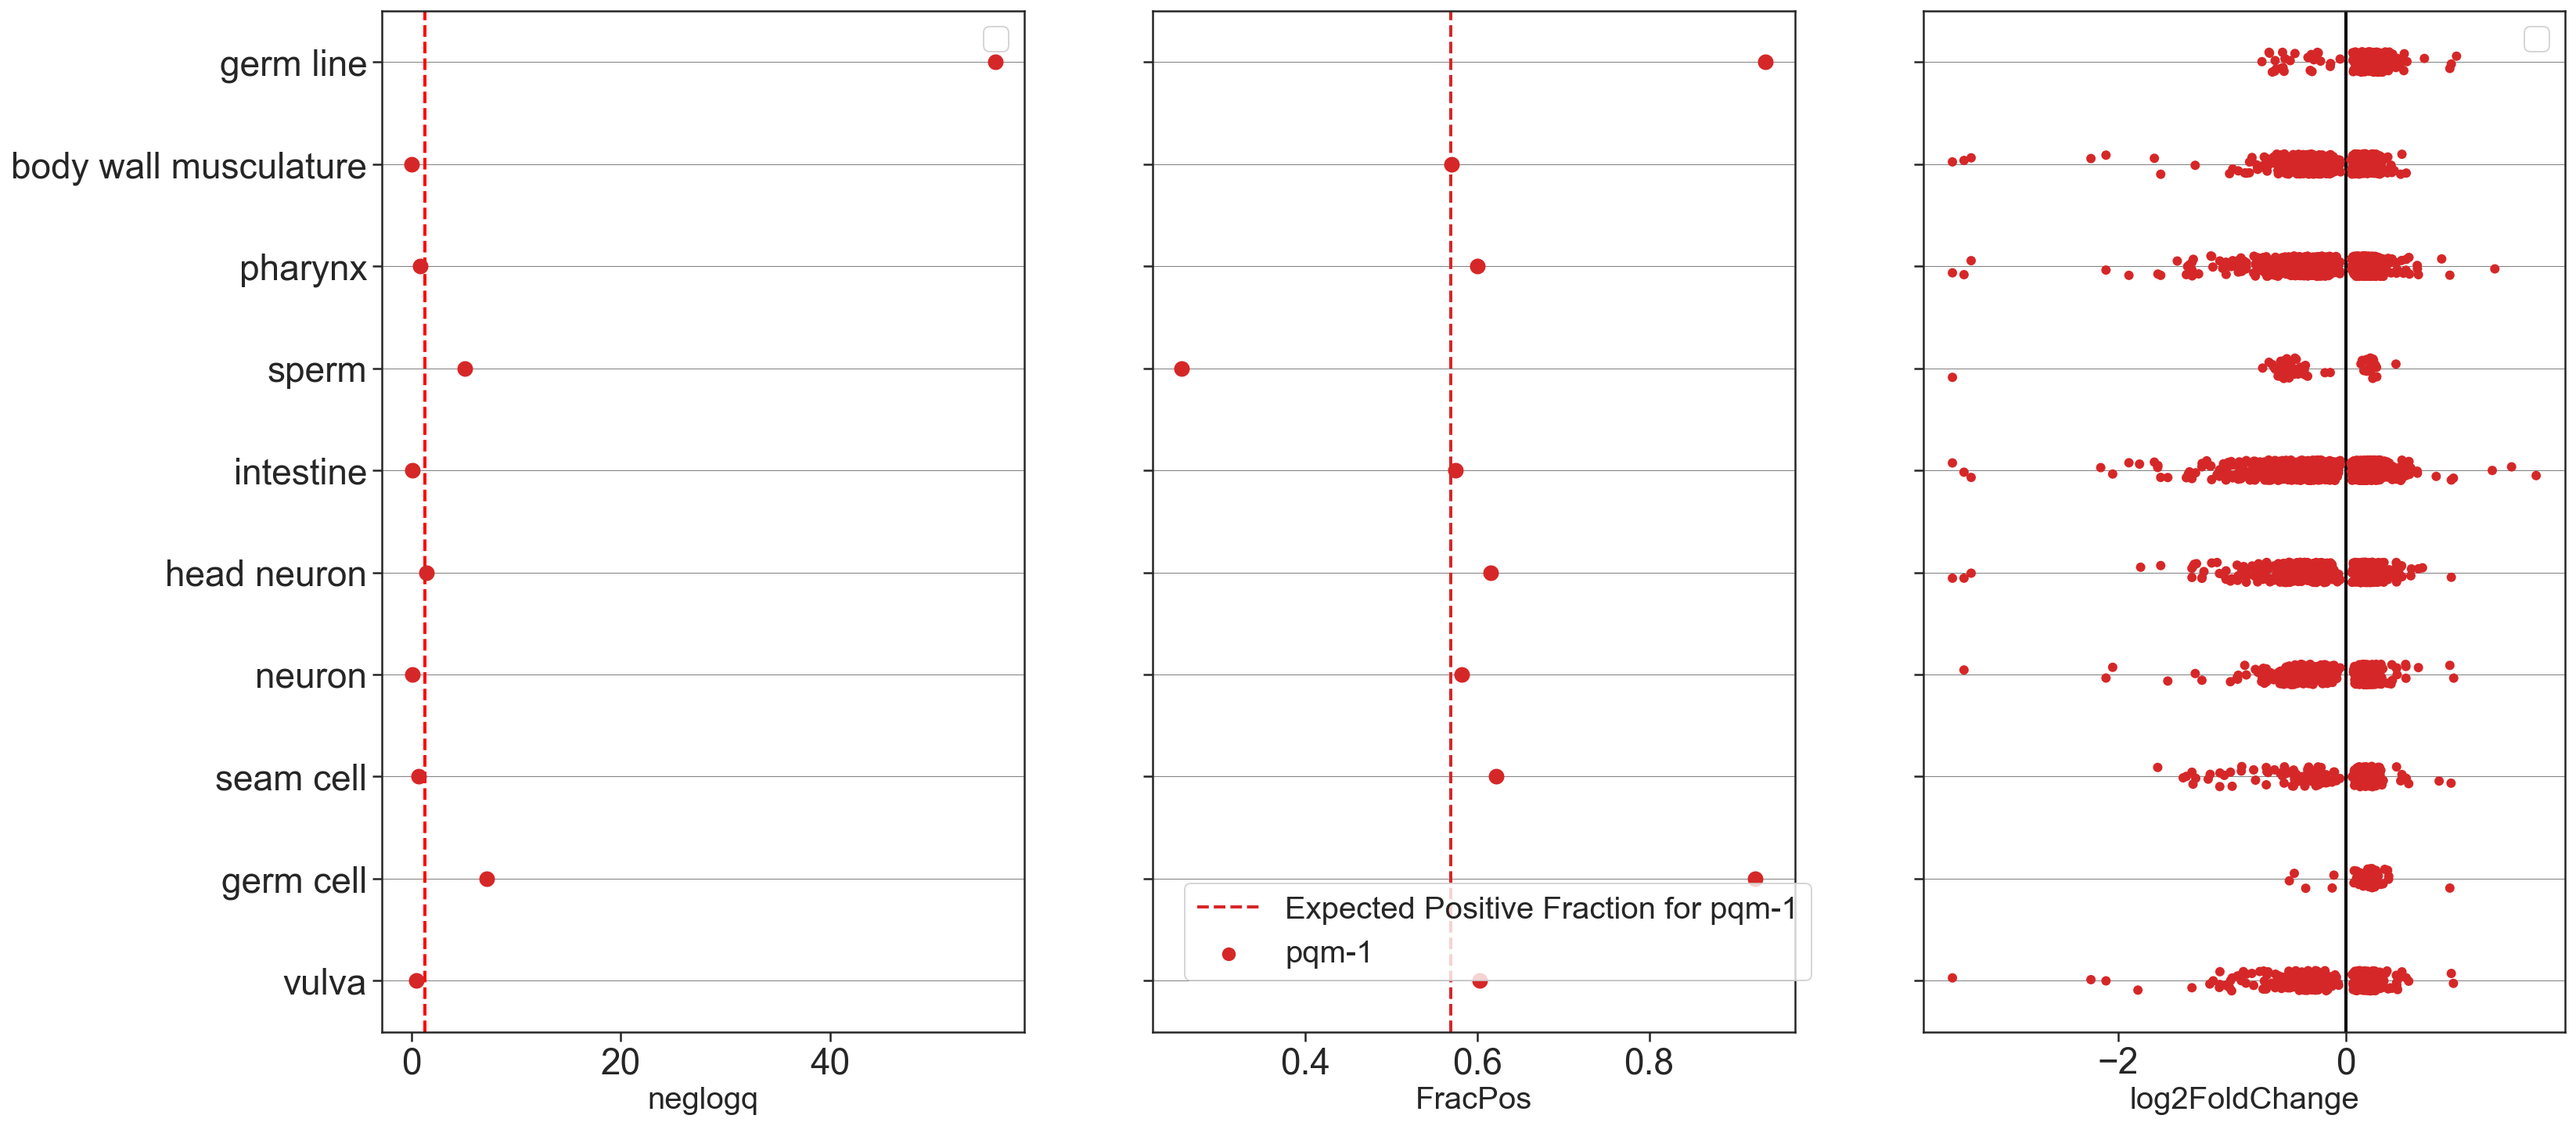

In [7]:
to_plot = data[(~data.tissue.isin(remove)) & (data.tissue.isin(tissues_plotted))].copy()
to_plot.tissue = to_plot.tissue.astype('category')
to_plot.tissue.cat.set_categories(tissues_plotted, inplace=True)
to_plot.sort_values('tissue', inplace=True)

fig, ax, legend = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha, hue='data', palette={'pqm-1': 'tab:red'})

In [8]:
res1 = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
res2 = pd.read_csv('../data/diff_exp/DE_pqm1_50.csv', index_col=0)
res2.columns = [c + '-pqm1' for c in res2.columns]
res = res1.join(res2, rsuffix='-pqm1')
res['sig-pqm1'] = (res['padj-pqm1'] < 0.05)
res = res.dropna(subset=['log2FoldChange50', 'log2FoldChange-pqm1'])
tissues = utils.load_tissues(res.index, 5, 30)
annotated_data = res.join(tissues.set_index('wbid')).dropna(subset=['tissue'])


tissues originally: 2359
tissues afterwards: 846


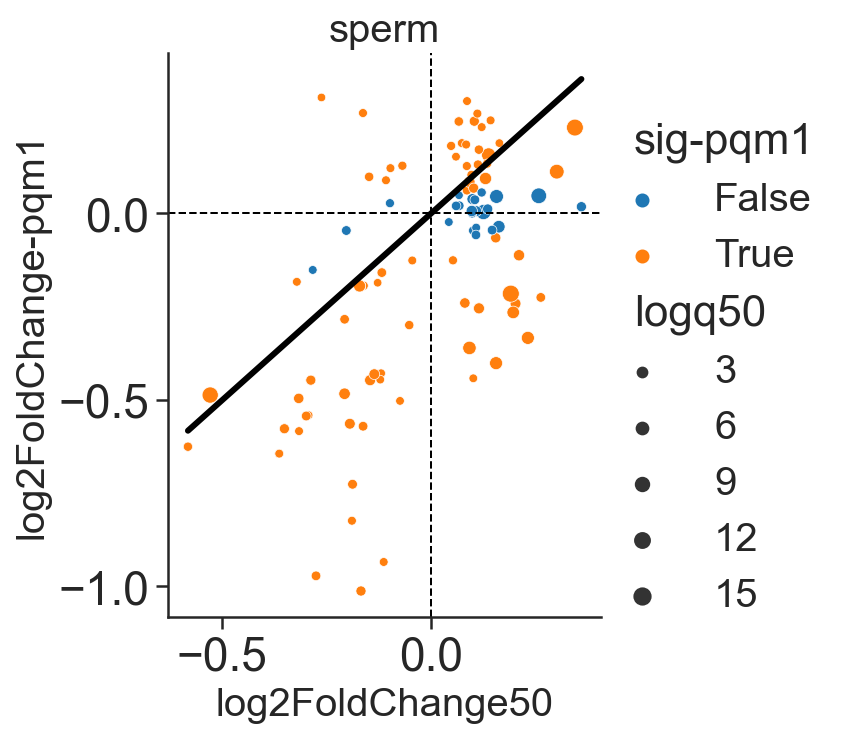

In [9]:
x = 'log2FoldChange50'
y = 'log2FoldChange-pqm1'
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='sperm', qval=0.05, kind='pearson')

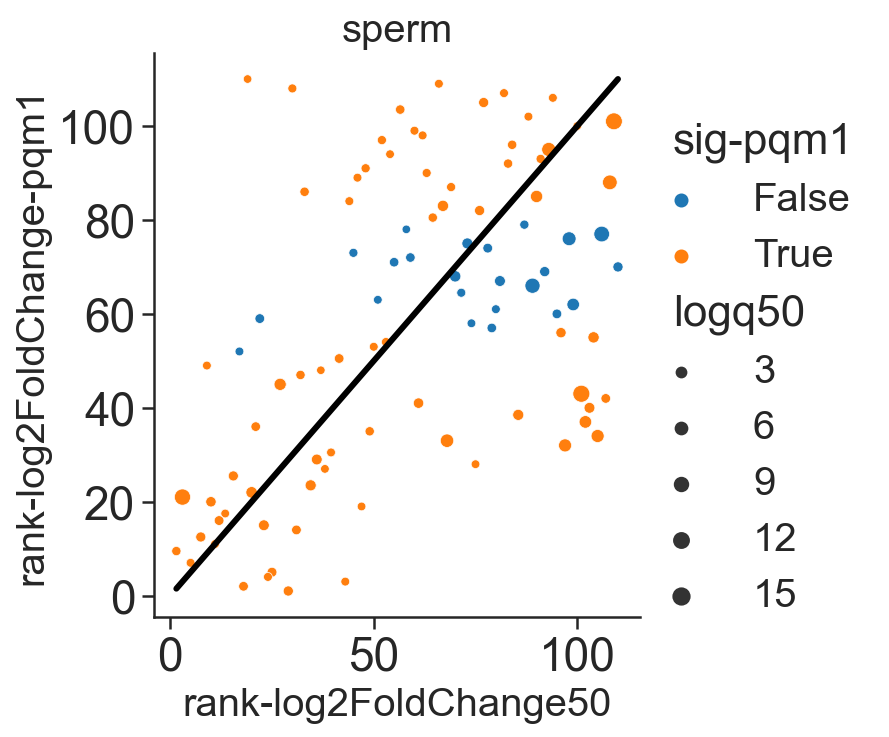

In [10]:
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='sperm', qval=0.05, kind='rank')

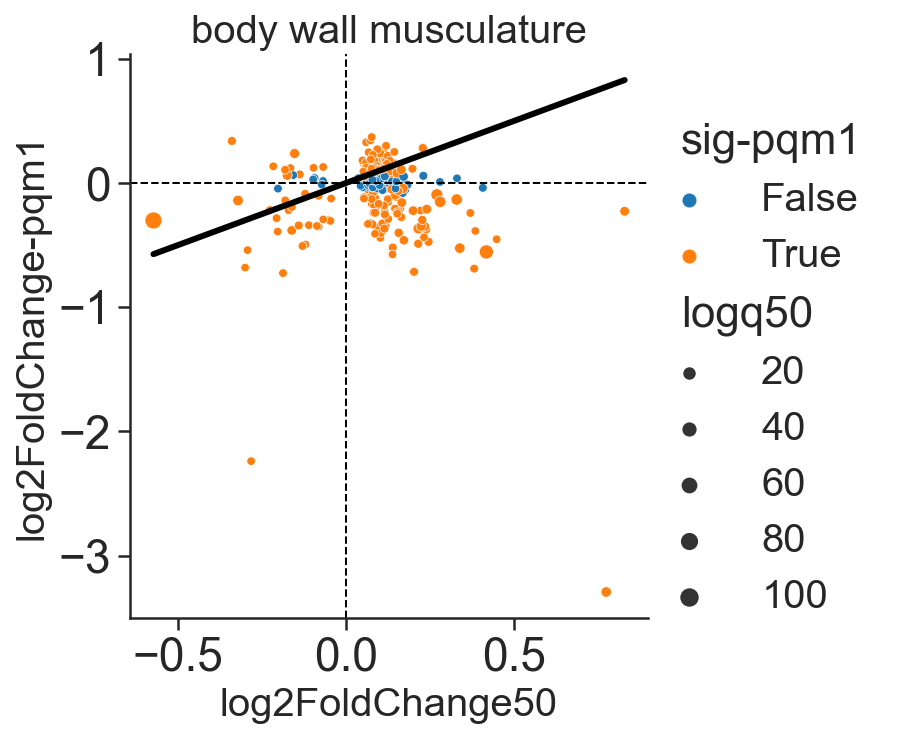

In [11]:
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='body wall musculature', qval=0.05, kind='pearson')

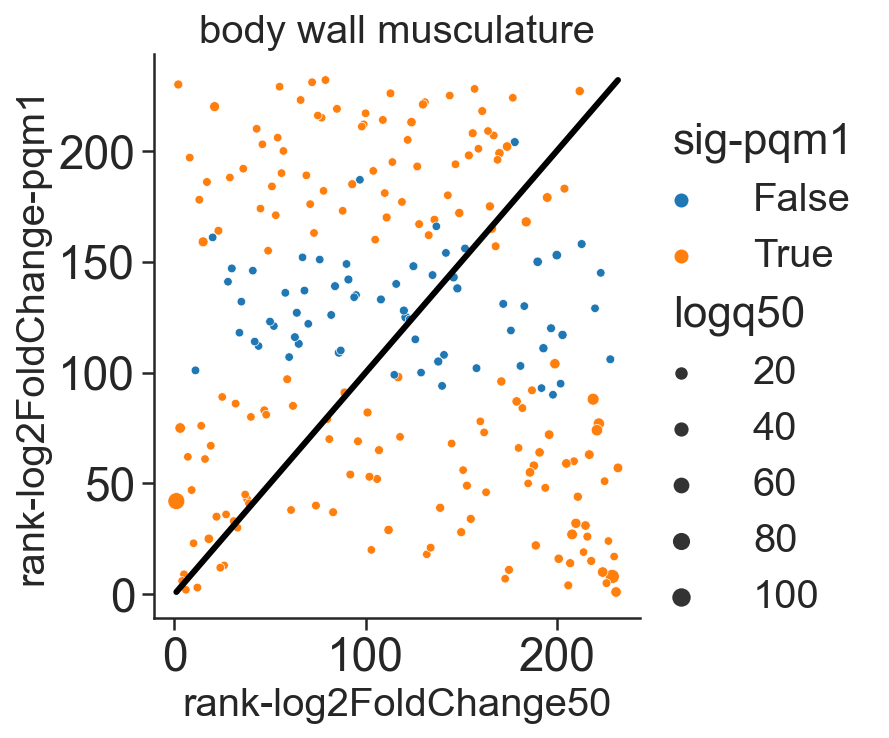

In [12]:
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='body wall musculature', qval=0.05, kind='rank')

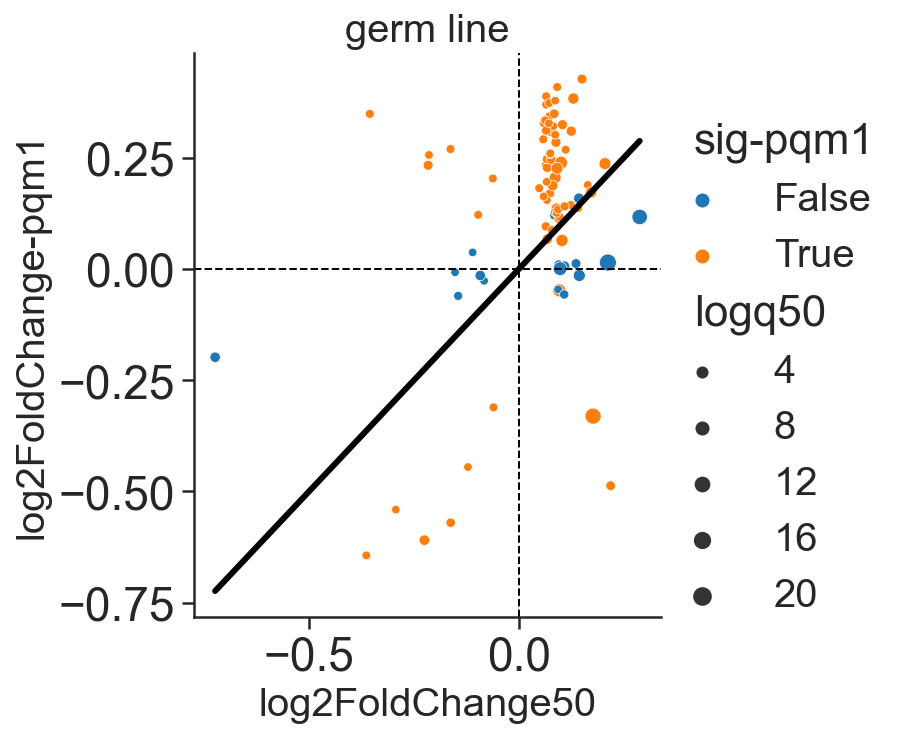

In [13]:
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='germ line', qval=0.05, kind='pearson')

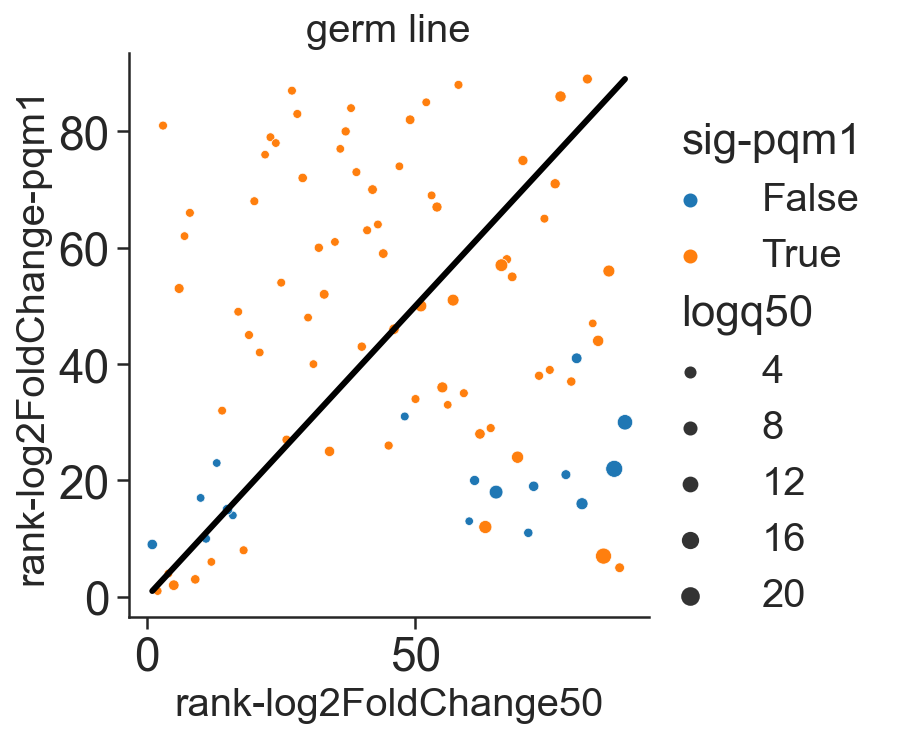

In [14]:
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='germ line', qval=0.05, kind='rank')

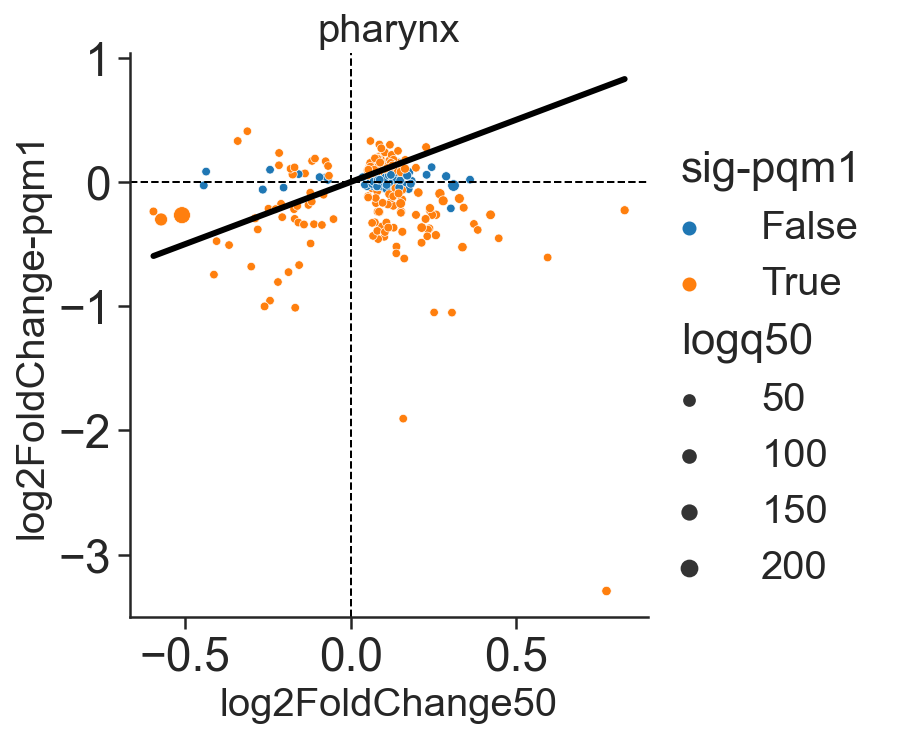

In [15]:
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='pharynx', qval=0.05, kind='pearson')

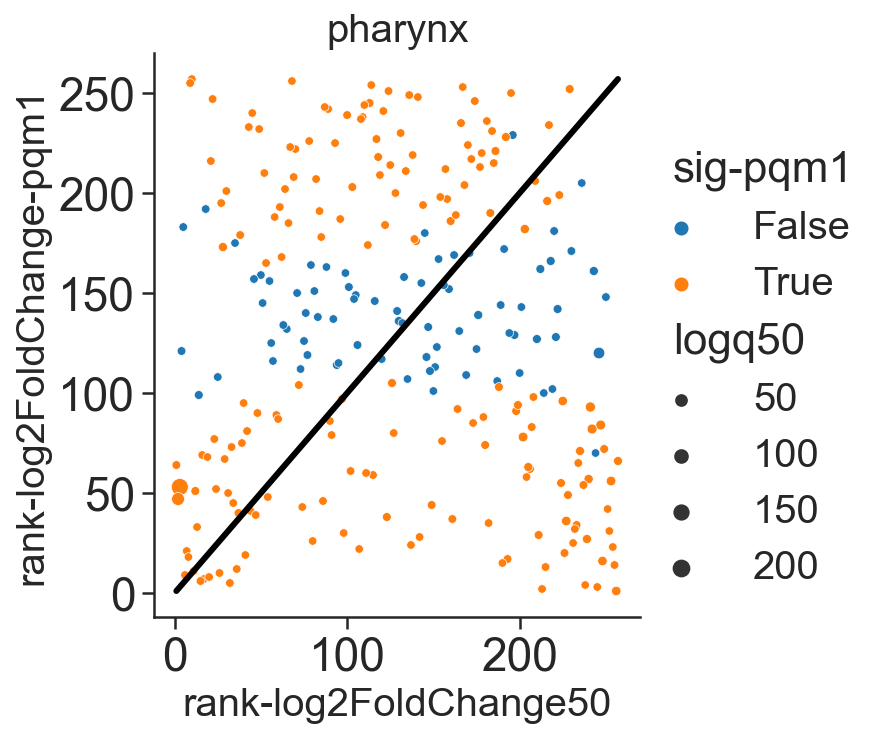

In [16]:
utils.corr_plots(annotated_data, x, y, hue='sig-pqm1', size='logq50',
                 tissue='pharynx', qval=0.05, kind='rank')